In [3]:
import lsst.daf.persistence as dafPersist
 
import numpy as np

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import Utils.DiaSourceTools as DSTools
from astropy.time import Time

import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import re

from multiprocessing import Pool
from functools import partial

import astropy.coordinates as coord
import astropy.units as u

import lsst.daf.base as dafBase
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.deblender import SourceDeblendTask

import lsst.afw.math as afwMath

from astropy.table import Table

In [4]:
DATADIR="/datadec/cppm/jpreyes/CFHT_Jointcal_2"
directory = DATADIR+"/jointcal_ind_12days/"
butler = dafPersist.Butler(directory) 
filter = 'r'


In [5]:
def preConvolve(exposure, sigma=5):
    psf = exposure.getPsf()
    maskedImage = exposure.getMaskedImage()
    kWidth = (int(sigma * 7 + 0.5) // 2) * 2 + 1 # make sure it is odd
    #self.metadata.set("smoothingKernelWidth", kWidth)
    gaussFunc = afwMath.GaussianFunction1D(sigma)
    gaussKernel = afwMath.SeparableKernel(kWidth, kWidth, gaussFunc, gaussFunc)

    convolvedImage = maskedImage.Factory(maskedImage.getBBox())

    afwMath.convolve(convolvedImage, maskedImage, gaussKernel, afwMath.ConvolutionControl())
    #
    # Only search psf-smooth part of frame
    #
    goodBBox = gaussKernel.shrinkBBox(convolvedImage.getBBox())
    middle = convolvedImage.Factory(convolvedImage, goodBBox, afwImage.PARENT, False)
    #
    # Mark the parts of the image outside goodBBox as EDGE
    #
    #self.setEdgeBits(maskedImage, goodBBox, maskedImage.getMask().getPlaneBitMask("EDGE"))
    return convolvedImage

In [6]:
def detect_sources(exposure):
    threshold = 6
    doSmooth=True
    schema = afwTable.SourceTable.makeMinimalSchema()


    algMetadata = dafBase.PropertyList()

    config = SourceDetectionTask.ConfigClass()
    #config.thresholdPolarity = "both"
    config.thresholdValue = threshold
    config.reEstimateBackground = False
    #config.thresholdType = "pixel_stdev"

    detectionTask = SourceDetectionTask(config=config, schema=schema)

    measurement = SingleFrameMeasurementTask
    config = measurement.ConfigClass()

    measurement = measurement(schema, config=config, algMetadata=algMetadata)


    deblend = SourceDeblendTask
    config = SourceDeblendTask.ConfigClass()
    deblend = deblend(schema)

    table = afwTable.SourceTable.make(schema)
    
    results = detectionTask.run(table=table, exposure=exposure , doSmooth=doSmooth )

    sourcesCat = results.sources
    
    deblend.run(exposure, sourcesCat)
    
    

    measurement.run(measCat=sourcesCat, exposure=exposure)

    return sourcesCat

In [7]:
dayCoadd = butler.get("dayCoadd", dataId={"filter":'r',"tract":0, "patch":"10,14", 'date':'2006-04-26'})
refCoadd = butler.get("deepCoadd", dataId={"filter":'r',"tract":0, "patch":"10,14"})

dayCoadd_sources=detect_sources(dayCoadd)
refCoadd_sources=detect_sources(refCoadd)

In [8]:
match = afwTable.matchRaDec(dayCoadd_sources, refCoadd_sources, afwGeom.Angle(1./3600., afwGeom.degrees))

In [11]:
m.first["coord_ra"]

3.75458 rad

In [14]:
for m in match:
    print afwGeom.radToMas(m.distance)
    x1 = float(m.first["coord_ra"])
    y1 = float(m.first["coord_dec"])
    x2 = float(m.second["coord_ra"])
    y2 =  float(m.second["coord_dec"])
    
    print np.sqrt((x1-x2)**2 + (y1-y2)**2)

185.00327347
3.75524383875
1.47926504674e-06
112.133214884
3.75478826307
5.44636233631e-07
0.0
3.75570104104
0.0
17.3868230841
3.75486254382
1.39999863773e-07
261.634138425
3.75595994959
1.73368294323e-06
77.7562366574
3.75527388484
4.69335224925e-07
31.193482165
3.75529047503
2.48233916483e-07
27.8324970754
3.75529044929
2.21971970889e-07
99.7850665605
3.75543567398
7.97803385675e-07
314.318225993
3.75547063104
1.81003003908e-06
104.1850154
3.75462603463
5.2032494617e-07
185.00327347
3.75615980267
1.47932648052e-06
295.815603347
3.75529935366
1.74652008777e-06
156.300190084
3.75597232635
1.04427962539e-06
71.2249886595
3.75583037714
4.89675636822e-07
0.0
3.75592759017
0.0
0.0
3.75592759017
0.0
21.0714380123
3.75576481218
1.02773737705e-07
40.7757145033
3.75579501381
2.14245138592e-07
42.810087045
3.75579503618
2.30604858583e-07
23.2050588278
3.75524736679
1.70493627311e-07
38.5119112508
3.75469879908
1.89484321369e-07
369.993780831
3.75584188319
1.79383188347e-06
191.057374229
3.75521

3.75449893872
7.57957320046e-07
77.6346474717
3.75612764065
4.72037806025e-07
35.4463128615
3.75596571692
2.55988015772e-07
28.1698729942
3.75510559629
1.3649968529e-07
53.324708949
3.75510577572
2.96493494264e-07
71.8193660464
3.75512735843
5.70576358208e-07
112.385672723
3.75472629936
5.95858529724e-07
138.958683727
3.75473999539
7.31132487542e-07
146.568443585
3.75474017142
8.27497310488e-07
130.762896913
3.75550955362
9.44853105313e-07
71.0922299445
3.75494077246
3.7415403847e-07
10.647211201
3.75596670832
7.27281340649e-08
14.0849364971
3.75596672048
9.05558423944e-08
56.3397459884
3.75564436577
3.22376478729e-07
64.7644573456
3.75524902093
4.32934660096e-07
32.6726580626
3.75551316887
2.04425112855e-07
175.786499505
3.75597677738
8.58747043189e-07
153.679256325
3.75447940099
1.08430306736e-06
50.5975969646
3.75611341734
2.48423269594e-07
369.993780831
3.75441425022
2.96077642151e-06
31.941633603
3.75494746957
2.23603066897e-07
24.0054672382
3.75568643515
1.42624797432e-07
179.614

9.26071707066e-07
95.8741807817
3.75516176648
7.2736134651e-07
36.4968012258
3.75512438935
2.03782909914e-07
0.0
3.75444042652
0.0
0.0
3.75444042652
0.0
49.4646713548
3.75590085798
2.54593344776e-07
127.210783476
3.75539780379
9.37444060451e-07
116.106686849
3.75550453397
5.85518491114e-07
49.0812185069
3.75604395854
2.38377565143e-07
66.1356675353
3.75532755655
4.93624797236e-07
35.8438540347
3.75574297252
2.86426148594e-07
67.338876248
3.75586548717
3.37173522085e-07
67.338876248
3.75586548688
3.37210219551e-07
112.595621856
3.75466957281
5.65479734367e-07
58.7207613916
3.75486455358
4.07083183848e-07
147.018929435
3.75603088341
9.12958853906e-07
50.783960752
3.75532421691
2.46735809156e-07
51.4309162699
3.75532421552
2.49633134156e-07
82.0134804607
3.75585759816
5.15789846322e-07
39.4809158003
3.75590944045
1.92881762813e-07
56.3397459884
3.75557053353
3.84707143643e-07
47.3172415783
3.75494881367
3.21459377225e-07
185.00327347
3.75471617496
8.96911389982e-07
0.0
3.75521243631
0.0
2

In [25]:
patches = []
patches_file=open(DATADIR+"/patches.txt", "rb")
for line in patches_file:
    line = line.replace('\n','')
    text = re.split("=| ",line)
    patches.append(text[-1])
patches_file.close()

In [29]:
patches

['0,4',
 '0,5',
 '0,6',
 '0,7',
 '0,8',
 '0,9',
 '0,10',
 '0,11',
 '0,12',
 '0,13',
 '0,14',
 '0,15',
 '0,16',
 '0,17',
 '0,18',
 '0,19',
 '0,20',
 '0,21',
 '0,22',
 '0,23',
 '0,24',
 '1,4',
 '1,5',
 '1,6',
 '1,7',
 '1,8',
 '1,9',
 '1,10',
 '1,11',
 '1,12',
 '1,13',
 '1,14',
 '1,15',
 '1,16',
 '1,17',
 '1,18',
 '1,19',
 '1,20',
 '1,21',
 '1,22',
 '1,23',
 '1,24',
 '2,4',
 '2,5',
 '2,6',
 '2,7',
 '2,8',
 '2,9',
 '2,10',
 '2,11',
 '2,12',
 '2,13',
 '2,14',
 '2,15',
 '2,16',
 '2,17',
 '2,18',
 '2,19',
 '2,20',
 '2,21',
 '2,22',
 '2,23',
 '2,24',
 '3,4',
 '3,5',
 '3,6',
 '3,7',
 '3,8',
 '3,9',
 '3,10',
 '3,11',
 '3,12',
 '3,13',
 '3,14',
 '3,15',
 '3,16',
 '3,17',
 '3,18',
 '3,19',
 '3,20',
 '3,21',
 '3,22',
 '3,23',
 '3,24',
 '4,4',
 '4,5',
 '4,6',
 '4,7',
 '4,8',
 '4,9',
 '4,10',
 '4,11',
 '4,12',
 '4,13',
 '4,14',
 '4,15',
 '4,16',
 '4,17',
 '4,18',
 '4,19',
 '4,20',
 '4,21',
 '4,22',
 '4,23',
 '4,24',
 '5,4',
 '5,5',
 '5,6',
 '5,7',
 '5,8',
 '5,9',
 '5,10',
 '5,11',
 '5,12',
 '5,13',
 

In [36]:
butler.datasetExists("dayCoadd", dataId={"filter":'r',"tract":0, "patch":'10,10', 'date':'2006-05-24'})

True

In [38]:
count = 0
for patch in patches: 
    if butler.datasetExists("dayCoadd", dataId={"filter":'r',"tract":0, "patch":patch, 'date':'2006-05-24'}):
        count+=1
print count

419


In [39]:
count = 0
patches_bool = []
for patch in patches: 
    if butler.datasetExists("dayCoadd", dataId={"filter":'r',"tract":0, "patch":patch, 'date':'2006-05-24'}):
        patches_bool.append(True)
    else:
        patches_bool.append(False)


patches_bool = np.array(patches_bool)
patches = np.array(patches)
p = patches.copy()
p = p[patches_bool]

p_sub = np.random.choice(p, 100)
print p_sub

['7,4' '20,20' '5,22' '7,20' '5,13' '6,10' '23,8' '14,15' '23,22' '10,4'
 '13,16' '22,17' '9,12' '18,16' '7,19' '6,11' '11,13' '21,23' '7,11'
 '12,14' '21,13' '6,12' '12,21' '11,8' '10,17' '23,9' '17,9' '10,12' '23,6'
 '8,16' '20,5' '16,6' '13,10' '19,11' '23,9' '13,13' '21,5' '4,14' '20,24'
 '7,10' '11,12' '6,23' '13,10' '14,11' '19,22' '11,17' '6,18' '9,7' '6,10'
 '14,24' '10,19' '12,9' '4,23' '7,23' '15,18' '4,23' '9,9' '9,12' '5,11'
 '23,9' '5,15' '18,12' '20,16' '10,15' '14,21' '7,24' '10,12' '9,20' '4,22'
 '7,11' '16,19' '4,9' '8,23' '10,19' '13,10' '14,6' '12,20' '22,9' '9,9'
 '17,4' '13,15' '20,14' '10,21' '8,19' '7,23' '7,5' '16,20' '4,16' '15,7'
 '6,10' '21,23' '12,13' '10,12' '21,23' '19,17' '12,12' '6,11' '23,9'
 '14,16' '10,4']


In [47]:
dayCoadd_sources = None
refCoadd_sources = None
for patch in patches: 
    if butler.datasetExists("dayCoadd", dataId={"filter":'r',"tract":0, "patch":patch, 'date':'2006-05-24'}) and butler.datasetExists("deepCoadd", dataId={"filter":'r',"tract":0, "patch":patch}):
            try:
                dayCoadd = butler.get("dayCoadd", dataId={"filter":'r',"tract":0, "patch":patch, 'date':'2006-05-24'})
                refCoadd = butler.get("deepCoadd", dataId={"filter":'r',"tract":0, "patch":patch})

                if dayCoadd_sources is None:
                    refCoadd_sources=detect_sources(refCoadd)
                    dayCoadd_sources=detect_sources(dayCoadd)

                else:
                    refCoadd_sources.extend(detect_sources(refCoadd))
                    dayCoadd_sources.extend(detect_sources(dayCoadd))
            except Exception, e:
                print e
                pass
                
           
        

In [48]:
multi_matches = afwTable.MultiMatch(dayCoadd_sources.schema, {'visit':'I'}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))


    
multi_matches.add(dayCoadd_sources, {'visit':0})
multi_matches.add(refCoadd_sources, {'visit':1})
    
results = multi_matches.finish(removeAmbiguous=False) 


In [49]:
lcs = DSTools.get_light_curves_from_multimatch_results2(results)
t_lcs = DSTools.threshold_light_curves(lcs, 2)
f_lcs = []
for lc in t_lcs:
        f_lcs.append(build_lightcurve(lc, "base_CircularApertureFlux_4_5_flux"))
        

In [50]:
diff_ra = []
diff_dec = []

for lc in f_lcs:
    diff_ra.append(lc[0]["ra"]-lc[1]["ra"])
    diff_dec.append(lc[0]["dec"]-lc[1]["dec"])
diff_ra = np.multiply(diff_ra,3600)
diff_dec = np.multiply(diff_dec,3600)

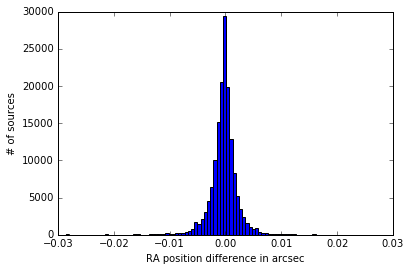

In [51]:

plt.hist(diff_ra, bins = 100) 
plt.xlabel("RA position difference in arcsec")
plt.ylabel("# of sources")
#plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
plt.show()

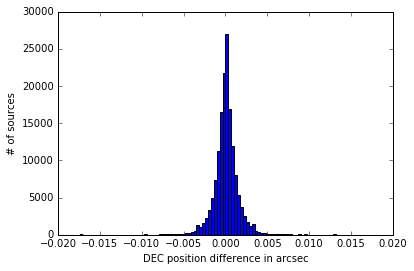

In [52]:
plt.hist(diff_dec, bins = 100)    
plt.xlabel("DEC position difference in arcsec")
plt.ylabel("# of sources")
#plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
plt.show()

In [29]:
patch = patches[205]
if butler.datasetExists("dayCoadd", dataId={"filter":'r',"tract":0, "patch":patch, 'date':'2006-04-23'}) and butler.datasetExists("deepCoadd", dataId={"filter":'r',"tract":0, "patch":patch}):
        print "exists"
        dayCoadd = butler.get("dayCoadd", dataId={"filter":'r',"tract":0, "patch":patch, 'date':'2006-04-23'})
        dayCoaddArray = dayCoadd.getMaskedImage().getImage().getArray()
        refCoadd = butler.get("deepCoadd", dataId={"filter":'r',"tract":0, "patch":patch})
        refCoaddArray = refCoadd.getMaskedImage().getImage().getArray()
               

exists


In [30]:
patch = patches[205]
print patch

9,20


In [32]:
diffArray = dayCoaddArray - refCoaddArray

imageF = afwImage.ImageF(diffArray)
ds9.mtv(imageF)

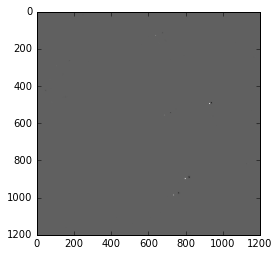

In [61]:

ds9.mtv(dayCoadd)

In [86]:

ds9.mtv(dayCoadd, frame=1)
#cImage = preConvolve(dayCoadd)
ds9.mtv(refCoadd, frame=2)


In [79]:
exp = afwImage.ExposureF()
exp.setMaskedImage(cImage)
exp.setPsf(dayCoadd.getPsf())

In [80]:
detect_sources(exp)